# Predicting Stock Returns Using LightGBM: A Quantitative Approach

*by David Yang, PhD and Ryan Chen, PhD*

## Introduction

In quantitative finance, data-driven strategies are critical for gaining an edge in predicting stock returns. The integration of financial theory with advanced **machine learning algorithms**, such as **LightGBM**, is transforming how portfolio managers analyze and navigate markets.

[LightGBM](https://lightgbm.readthedocs.io/en/stable/), short for **Light Gradient Boosting Machine**, stands out as an ideal tool for predicting stock returns due to its efficiency with large datasets, its ability to process high-dimensional data, and its speed. In this blog, we will show how to leverage Tiingo’s financial data in combination with LightGBM to forecast stock returns. Through a simple long-only strategy, backtested over 20 years, we achieve a monthly alpha of 0.63%, presenting a robust framework that quantitative researchers/traders can apply to enhance their strategies.

## Firms' Core Characteristics and Stock Performance

The performance of firms in the stock market is strongly influenced by their core characteristics. In a seminal paper, **Fama and French (1992)** showed that firms with higher **book-to-market ratios** consistently outperform those with lower ratios. Similarly, **smaller firms** tend to yield higher returns than larger ones—a phenomenon known as the **size premium** (first introduced by **Banz (1981)** and reviewed extensively by **Van Dijk (2011)**). These findings laid the foundation for a broad stream of asset pricing literature.

Later, **Jegadeesh and Titman (1993, 2001)** extended this by constructing **momentum portfolios**, where investors buy outperforming stocks while shorting underperforming ones. The result was abnormally profitable strategies that have continued to influence factor-based investing. These findings have fueled the development of **factor indices**, where investors target top-performing stocks while selling underperformers.

The literature on such **market anomalies** is vast, with notable reviews by **Subrahmanyam (2010)**, **Green et al. (2013)**, and **Harvey et al. (2016)**, who analyzed their persistence and practical application in today’s markets.

## The Role of Machine Learning in Stock Prediction

The rise of artificial intelligence (AI) and machine learning (ML) has transformed how quantitative traders approach stock prediction. Advanced algorithms now enable the processing of vast amounts of data with unprecedented precision. Techniques such as random forests, boosted trees, and neural networks have expanded the horizons of predictive modeling. In particular, machine learning methods have shown great potential in modeling stock returns and improving prediction accuracy (**Gu, Kelly, and Xiu, 2020**).

However, many of the current machine learning models rely primarily on price or technical data, neglecting other important factors that asset pricing literature highlights (**Coqueret and Guida, 2019**). **LightGBM** offers a solution to this by effectively handling **non-linearity**, employing **regularization**, and working well with **large, complex datasets**, making it well-suited for a wide array of financial applications. 

## LightGBM: Why Boosted Trees Are Effective for Stock Prediction

LightGBM is built on **gradient boosting**, an ensemble learning technique where weak learners (typically decision trees) are sequentially trained, each one correcting the errors of the last. This results in a robust predictive model that can generalize effectively across complex, high-dimensional datasets.

Designed for speed and memory efficiency, LightGBM is particularly adept at handling **large, sparse datasets**—a frequent occurrence in financial data. For quantitative traders, this translates into faster, more reliable predictions when modeling stock returns, even when working with datasets containing thousands of features or millions of rows.

LightGBM’s flexibility allows it to process categorical and continuous data with ease, making it highly adaptable for forecasting stock returns based on a wide range of factors, not just price movements. Its strong predictive capabilities and efficient handling of data make it a powerful tool in modern financial modeling, enabling portfolio managers to gain deeper insights and improve their decision-making processes.


*Note: Backtesting results are not indicative of future performance. These strategies are based on historical data, and there is no guarantee that they will yield the same outcomes in live trading.*

---


## Data Acquisition

In this example, we concentrate on U.S. stocks, a highly liquid and well-documented market that provides a clear advantage by avoiding complexities tied to different currencies and regulatory frameworks often encountered in international markets. The U.S. stock market also offers extensive coverage of financial metrics, making it an ideal environment for implementing quantitative strategies effectively.

We gather **daily price data** and **quarterly stock characteristics** for the top 1,000 U.S. stocks by market capitalization, spanning from **January 2000 to August 2024** (refer to the appendix for the code to download stock tickers). This dataset comprises common equities, ensuring high-quality and consistent data. Using **Tiingo’s premium packages**, we access point-in-time data, eliminating survivorship bias, which is crucial for ensuring robust backtesting.

The dataset includes **monthly discrete total returns**, which are adjusted for stock splits and dividends, and all prices are presented in **U.S. dollars**. Our goal is to predict **1-month future return**, leveraging a set of carefully selected features. These features include fundamental, momentum, and volume-based metrics. The decision to limit the model to those features simplifies the process while showing that even relatively simple strategies combined with quality data can deliver **strong predictive performance**. This approach encourages easy replication by other researchers/traders.

To prevent look-ahead bias, a **36-month rolling window** is implemented for training the model. This ensures that only historical data is used for predictions, preserving the model's integrity. Our label is **12-month future Sharpe ratio**. With a 36-month training window and a 12-month prediction horizon (label), the model requires a minimum of **48 months of data** for each iteration. The model is **retrained monthly**, with the holding period also aligned to a **monthly cadence**.

In [ ]:
import os              # Interacts with the operating system
from tiingo import TiingoClient  # Import the Tiingo client to access financial data.
import pandas as pd     # Import the pandas library for data manipulation and analysis.
import pickle           # Used to serialize Python objects and save them as files.
from io import StringIO # StringIO allows reading and writing strings as files in memory.

In [ ]:
# Set your Tiingo API key
# os.environ['TIINGO_API_KEY'] = "YOUR TIINGO API KEY HERE"  # Store your Tiingo API key as an environment variable.

In [ ]:
def initialize_tiingo_client():  # Define a function to initialize the Tiingo API client.
    config = {  # Configuration dictionary to hold settings for the Tiingo client.
        'session': True,  # Use a session to maintain a persistent connection for better performance.
        'api_key': os.getenv('TIINGO_API_KEY')  # Retrieve the API key from the environment variable.
    }
    if not config['api_key']:  # Check if the API key is missing.
        raise Exception("API key not found! Please set your Tiingo API key as an environment variable.")  # Raise an error if the key is missing.
    return TiingoClient(config)  # Initialize and return a TiingoClient object using the provided configuration.

In [ ]:
def clear_directory(dir_path, file_extension="pickle"):  # Define a function that clears files with a specific extension in a given directory.
    file_list = [f for f in os.listdir(dir_path) if f.endswith(file_extension)]  # List all files in the directory with the specified extension.
    for f in file_list:  # Iterate over each file in the list.
        os.remove(os.path.join(dir_path, f))  # Remove the file from the directory.

This function clears all files with a specific extension (by default, `.pickle`) from a directory. It can be useful to remove old data files before saving new ones.

In [ ]:
def read_tickers_from_file(file_path):  # Define a function to read stock tickers from a file.
    with open(file_path, 'r') as f:  # Open the file in read mode.
        tickers = [line.strip() for line in f.readlines()]  # Read each line, remove leading/trailing spaces, and store them in a list.
    return tickers  # Return the list of tickers.

The following code presents an efficient process for acquiring and handling both **daily stock price data** and **quarterly fundamental data** through the **Tiingo API**. To ensure consistency in backtesting, the **quarterly fundamental data** is interpolated to a daily frequency using **forward-filling**, allowing for seamless integration with daily stock prices. This alignment ensures the most recent financial metrics are synchronized with daily price data, resulting in a **unified dataset**.

By maintaining this alignment, portfolio managers can simulate realistic trading scenarios where decisions are based on the latest available data, ensuring both **price (momentum)** and **fundamental factors** are fully considered when executing trades.

##### Downloading Stock Price Data
This function takes a list of tickers and fetches historical stock data from Tiingo. The data is then combined into a single `pandas` DataFrame.

*Note: If fetching the data fails for a ticker, the error is printed, and the code continues to the next ticker.*

In [ ]:
def download_stock_data(client, ticker_list, start_date, end_date):  # Define a function to download stock data.
    all_data_frames = []  # Create a list to store the individual DataFrames.
    for ticker in ticker_list:  # Loop over each ticker symbol.
        try:
            # Fetch historical stock data from Tiingo API in JSON format.
            historical_data = client.get_ticker_price(ticker,
                                                      fmt='json',
                                                      startDate=start_date,
                                                      endDate=end_date,
                                                      frequency='daily')
            df = pd.DataFrame(historical_data)  # Convert the JSON data into a pandas DataFrame.
            df['stockid'] = ticker  # Add a new column to identify which stock the data belongs to.
            df.reset_index(drop=True, inplace=True)  # Reset the index to clean the DataFrame.
            all_data_frames.append(df)  # Append the DataFrame to the list for combining later.
        except Exception as e:  # If an error occurs during data fetching.
            print(f"Failed to fetch data for {ticker}: {e}")  # Print the error message.
    
    combined_df = pd.concat(all_data_frames, ignore_index=True)  # Combine all individual DataFrames into one.
    return combined_df  # Return the combined DataFrame.

##### Downloading Stock Fundamentals Data
This function downloads fundamental data (financial statement items) for each ticker, reshapes the data, (forward) fills in missing dates, and combines everything into a single DataFrame.

In [ ]:
def download_fundamentals(client, ticker_list, start_date, end_date):
    # Initialize an empty DataFrame to store all data.
    combined_df = pd.DataFrame()

    # Loop through each ticker.
    for ticker in ticker_list:
        try:
            # Fetch fundamental data from Tiingo API.
            fundamentals_stmnts = client.get_fundamentals_statements(
                ticker,
                startDate=start_date,
                endDate=end_date,
                asReported=True,  # Ensure it's as reported by SEC (the original, not the corrected statement)
                fmt='json'
            )

            if not fundamentals_stmnts:
                print(f"No data for {ticker}.")
                continue

            # Create a list to store rows of the final DataFrame
            data_rows = []

            for record in fundamentals_stmnts:
                date = record['date']
                year = record['year']
                quarter = record['quarter']
                
                if 'statementData' in record:
                    statement_data = record['statementData']

                    # Extract and flatten each financial statement category.
                    for category in ['incomeStatement', 'balanceSheet', 'cashFlow', 'overview']:
                        if category in statement_data:
                            for item in statement_data[category]:
                                data_code = item.get('dataCode')
                                value = item.get('value')
                                if data_code:
                                    data_rows.append({
                                        'date': date,
                                        'year': year,
                                        'quarter': quarter,
                                        'stockid': ticker,
                                        'dataCode': data_code,
                                        'value': value
                                    })

            # Convert the list of rows into a DataFrame
            if data_rows:
                df = pd.DataFrame(data_rows)

                # Remove records where quarter is 0 (it is not a quarterly data).
                df = df[df['quarter'] != 0]

                # Pivot the DataFrame to reshape it.
                df = df.pivot(index=['date', 'year', 'quarter', 'stockid'], columns='dataCode', values='value')
                df.reset_index(inplace=True)  # Reset the index.

                # Convert 'date' column to datetime format.
                df['date'] = pd.to_datetime(df['date'], errors='coerce')

                # Filter out rows where 'date' conversion failed.
                df = df.dropna(subset=['date'])

                # Set the 'date' column as the index for reindexing.
                df.set_index('date', inplace=True)

                # Create a full date range between the start and end date.
                full_date_range = pd.date_range(start=df.index.min(), end=end_date, freq='D')

                # Reindex the DataFrame with the full date range and forward-fill missing values.
                df = df.reindex(full_date_range).ffill()

                # Reset the index after reindexing.
                df.reset_index(inplace=True)

                # Rename the index column back to 'date'.
                df.rename(columns={'index': 'date'}, inplace=True)

                # Reassign the 'stockid' column after resetting the index.
                df['stockid'] = ticker

                # Combine with the existing DataFrame.
                combined_df = pd.concat([combined_df, df], ignore_index=True)

        except Exception as e:
            print(f"Error for {ticker}: {e}")

    # Return the combined DataFrame after processing all tickers.
    return combined_df

##### Saving Data as Pickle Files
This function saves the `pandas` DataFrame as a pickle file, allowing us to load the data quickly later on.

In [ ]:
def save_as_pickle(df, file_path):  # Define a function to save a DataFrame as a pickle file.
    with open(file_path, 'wb') as f:  # Open the file in binary write mode.
        pickle.dump(df, f)  # Save the DataFrame to the file using pickle.

##### Main Execution Block
- We specify the target directory where data will be saved.
- We initialize the Tiingo client.
- We read the stock tickers from a text file.
- We download stock price data for the specified date range.
- We download fundamentals data for the specified date range.
- We save both datasets as pickle files for future use.

*Note: Pickle files are generally better than CSV files for storing Python objects, especially when preserving data structure and type information is crucial. Pickle preserves the exact structure and data types of your pandas DataFrame (such as integers, floats, dates, and categorical data), while CSV will not preserve types perfectly. For example, CSV might store all numbers as strings, requiring post-processing to restore the correct types when reloading the data.*

In [ ]:
if __name__ == '__main__':  
    target_directory = "SET YOUR DIRECTORY"  # Set the directory to store the data files.
    os.chdir(target_directory)  # Change the current working directory to the target directory.

    client = initialize_tiingo_client()  # Initialize the Tiingo client.

    ticker_file_path = 'YOUR TICKER FILE ADDRESS'  # Define the path to the text file containing tickers.
    US_tickers = read_tickers_from_file(ticker_file_path)  # Read tickers from the text file.

    start_date = '2000-01-01'  # Define the start date for downloading stock data.
    end_date = '2024-09-10'  # Define the end date for downloading stock data.

    stock_price_data = download_stock_data(client, US_tickers, start_date, end_date)  # Download stock price data.
    save_as_pickle(stock_price_data, os.path.join(target_directory, "US_Combined_Stock_Price.pickle"))  # Save the stock price data as a pickle file.

    fundamentals_data = download_fundamentals(client, US_tickers, start_date, end_date)  # Download fundamental data.
    save_as_pickle(fundamentals_data, os.path.join(target_directory, "US_Combined_Stock_Fundamentals.pickle"))  # Save the fundamental data as a pickle file.

    print("Data download and pickle file save completed.")  # Print a message indicating the process is done.

In [ ]:
from IPython.display import display

# Define a function to load a pickle file
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Load the stock price and fundamentals data from pickle files
stock_price_pickle = os.path.join(target_directory, "US_Combined_Stock_Price.pickle")
fundamentals_pickle = os.path.join(target_directory, "US_Combined_Stock_Fundamentals.pickle")

stock_price_data = load_pickle(stock_price_pickle)
fundamentals_data = load_pickle(fundamentals_pickle)

# Select the top 500 rows to check
top_500_stock_price_data = stock_price_data.head(500)
top_500_fundamentals_data = fundamentals_data.head(500)

# Display the dataframes interactively
print("Top 500 rows of Stock Price Data:")
display(top_500_stock_price_data)  

print("\nTop 500 rows of Fundamentals Data:")
display(top_500_fundamentals_data) 

---

## Feature and Label Engineering


With **tree-based models** like **LightGBM**, highly correlated variables don’t disrupt performance. In fact, incorporating many correlated features gives the model flexibility to discern the unique contribution of each variable (Coqueret and Guida, 2019, 2020). In our model, we use well-known **financial factors** such as:

- Market Capitalization
- Price-to-Book Ratio
- Momentum
- Profitability
- Growth
- Volatility (Risk)

The dataset is not static—company attributes and the number of available stocks vary over time, making the backtesting process more complex. However, this variability mirrors the **dynamic nature** of real markets, allowing for more accurate and robust analysis. This approach ensures that our model adapts to changing conditions, enhancing its practical relevance.



*Note: Coqueret and Guida (2020) implemented a strategy using Xgboost that filters stocks based on having data for the maximum number of dates available in the dataset. This approach ensures that only stocks with complete data for all time points are considered. While this method has its merits, we chose not to adopt it in our analysis due to potential concerns about survivorship bias.*

In [ ]:
import pandas as pd
import numpy as np
import pickle

# Load the datasets from pickle files
with open('US_Combined_Stock_Price.pickle', 'rb') as f:
    stock_price_data = pickle.load(f)

with open('US_Combined_Stock_Fundamentals.pickle', 'rb') as f:
    stock_fundamentals_data = pickle.load(f)

# Convert 'date' columns to datetime type in both datasets
stock_price_data['date'] = pd.to_datetime(stock_price_data['date']).dt.tz_localize(None)
stock_fundamentals_data['date'] = pd.to_datetime(stock_fundamentals_data['date'])

# Merge datasets on 'stockid' and 'date'
merged_data = pd.merge(stock_price_data, stock_fundamentals_data, on=['stockid', 'date'], how='inner')
merged_data = merged_data.sort_values(by=['stockid', 'date'])
#print(merged_data.columns)

**Feature Engineering**

In [ ]:
# -----------------------------
# Market Capitalization (MKTCAP)
# -----------------------------
merged_data['MKTCAP'] = merged_data['shareswa'] * merged_data['adjClose']

# -----------------------------
# Asset Efficiency Metrics
# -----------------------------
# Asset Turnover (Revenue / Total Assets)
merged_data['ASSET_TURNOVER'] = merged_data['revenue'] / (merged_data['assetsCurrent'] + merged_data['assetsNonCurrent'])

# Inventory Turnover (Cost of Revenue / Inventory)
merged_data['INVENTORY_TURNOVER'] = merged_data['costRev'] / merged_data['inventory']

# Receivables Turnover (Revenue / Accounts Receivable)
merged_data['REC_TURNOVER'] = merged_data['revenue'] / merged_data['acctRec']

# Payables Turnover (Cost of Revenue / Accounts Payable)
merged_data['PAYABLES_TURNOVER'] = merged_data['costRev'] / merged_data['acctPay']


# ----------------------
# Profitability Measures
# ----------------------
# EBIT on Book Value (EBIT / Equity)
merged_data['EBIT_BV'] = merged_data['ebit'] / merged_data['equity']

# EBIT on Total Assets (EBIT / Total Assets)
merged_data['EBIT_TA'] = merged_data['ebit'] / merged_data['totalAssets']

# EBITDA Margin (EBITDA / Revenue)
merged_data['EBITDA_SALE'] = merged_data['ebitda'] / merged_data['revenue']

# Net Margin (Net Income / Revenue)
merged_data['NET_MARGIN'] = merged_data['netinc'] / merged_data['revenue']

# Net Income to Total Assets (Net Income / Total Assets)
merged_data['NI_AT'] = merged_data['netinc'] / merged_data['totalAssets']

# ----------------------
# Earnings and Cash Flow
# ----------------------
# EPS (Earnings Per Share)
merged_data['EPS'] = merged_data['eps']

# Diluted EPS (Earnings Per Share Diluted)
merged_data['EPS_DIL'] = merged_data['epsDil']

# EPS Growth (YoY Change)
merged_data['EPS_GR'] = merged_data.groupby('stockid')['eps'].pct_change(252)

# Free Cash Flow (FCF)
merged_data['FCF'] = merged_data['freeCashFlow']

# Free Cash Flow to Book Value (FCF / Equity)
merged_data['FCF_BV'] = merged_data['freeCashFlow'] / merged_data['equity']

# Free Cash Flow to Sales (FCF / Revenue)
merged_data['FCF_SALE'] = merged_data['freeCashFlow'] / merged_data['revenue']

# Free Cash Flow to Total Assets (FCF / Total Assets)
merged_data['FCF_TA'] = merged_data['freeCashFlow'] / merged_data['totalAssets']

# Free Cash Flow Yield (FCF / Market Cap)
merged_data['FCF_YIELD'] = merged_data['freeCashFlow'] / merged_data['MKTCAP']

# Operating Cash Flow to Sales (OCF / Revenue)
merged_data['OCF_SALES'] = merged_data['ncfo'] / merged_data['revenue']

# ------------------------
# Valuation Ratios (PE/PB)
# ------------------------
# Price-to-Book Ratio (Market Cap / Equity)
merged_data['PB'] = merged_data['MKTCAP'] / merged_data['equity']

# Price-to-Earnings Ratio (Price / EPS)
merged_data['PE'] = merged_data['adjClose'] / merged_data['eps']

# ---------------------
# Leverage & Debt Ratios
# ---------------------
# Debt to Equity (Total Debt / Equity)
merged_data['DEBT_EQUITY'] = merged_data['debt'] / merged_data['equity']

# Debt to EBITDA (Total Debt / EBITDA)
merged_data['DEBT_EBITDA'] = merged_data['debt'] / merged_data['ebitda']

# Debt to Cash Flow (Total Debt / Operating Cash Flow)
merged_data['DEBT_CF'] = merged_data['debt'] / merged_data['ncfo']

# Debt to Sales (Total Debt / Revenue)
merged_data['DEBT_SALE'] = merged_data['debt'] / merged_data['revenue']

# Debt to Assets (Total Liabilities / Total Assets)
merged_data['DEBT_AT'] = merged_data['totalLiabilities'] / merged_data['totalAssets']

# Interest Coverage Ratio (EBIT / Interest Expense)
merged_data['INT_COVERAGE'] = merged_data['ebit'] / merged_data['intexp']

# --------------------------
# Momentum and Volatility
# --------------------------

# 11-Month Momentum
merged_data['MOM_11M_USD'] = merged_data.groupby('stockid')['adjClose'].pct_change(231)

# 5-Month Momentum
merged_data['MOM_5M_USD'] = merged_data.groupby('stockid')['adjClose'].pct_change(105)


# Volatility over 11 months 
merged_data['VOL11M_USD'] = (
    merged_data.groupby('stockid')['adjClose'].pct_change().rolling(window=231).std().reset_index(0, drop=True) * (231 ** 0.5)
)

# Volatility over 5 months
merged_data['VOL5M_USD'] = (
    merged_data.groupby('stockid')['adjClose'].pct_change().rolling(window=105).std().reset_index(0, drop=True) * (105 ** 0.5)
)

# Sharpe Ratios (Momentum divided by Annualized Volatility)

# Sharpe Ratio for 11 months
merged_data['MOM_SHARPE_11M_USD'] = merged_data['MOM_11M_USD'] / merged_data['VOL11M_USD']

# Sharpe Ratio for 5 months
merged_data['MOM_SHARPE_5M_USD'] = merged_data['MOM_5M_USD'] / merged_data['VOL5M_USD']



# ----------------------
# Turnover Metrics
# ----------------------
# 12-Month Share Turnover (Average Volume / Average Shares Outstanding (weighted average number of shares outstanding))
merged_data['SHARE_TURN_12M'] = (
    merged_data.groupby('stockid')['volume'].rolling(window=252).mean().reset_index(0, drop=True)
) / merged_data.groupby('stockid')['shareswa'].rolling(window=252).mean().reset_index(0, drop=True)

# 6-Month Share Turnover
merged_data['SHARE_TURN_6M'] = (
    merged_data.groupby('stockid')['volume'].rolling(window=126).mean().reset_index(0, drop=True)
) / merged_data.groupby('stockid')['shareswa'].rolling(window=126).mean().reset_index(0, drop=True)

# 3-Month Share Turnover
merged_data['SHARE_TURN_3M'] = (
    merged_data.groupby('stockid')['volume'].rolling(window=63).mean().reset_index(0, drop=True)
) / merged_data.groupby('stockid')['shareswa'].rolling(window=63).mean().reset_index(0, drop=True)

# -------------------------
# Average Daily Volume in USD
# -------------------------
# 12-Month ADV in USD
merged_data['ADV_12M_USD'] = (
    merged_data.groupby('stockid')['volume'].rolling(window=252).mean().reset_index(0, drop=True)
    * merged_data['adjClose']
)

# 6-Month ADV in USD
merged_data['ADV_6M_USD'] = (
    merged_data.groupby('stockid')['volume'].rolling(window=126).mean().reset_index(0, drop=True)
    * merged_data['adjClose']
)

# 3-Month ADV in USD
merged_data['ADV_3M_USD'] = (
    merged_data.groupby('stockid')['volume'].rolling(window=63).mean().reset_index(0, drop=True)
    * merged_data['adjClose']
)


**Labels Section**

In [ ]:
# 1-Month Forward Return (Future Return 1 month ahead, i.e., 21 trading days)
merged_data['R1M_USD'] = (
    merged_data.groupby('stockid')['adjClose'].shift(-21) / merged_data['adjClose'] - 1
)

# 1-Year Forward Return (Future Return 1 year ahead, i.e., 252 trading days)
merged_data['R1Y_USD'] = (
    merged_data.groupby('stockid')['adjClose'].shift(-252) / merged_data['adjClose'] - 1
)

# 1-Year Forward Volatility (Annualized Standard Deviation of Returns over the next 252 trading days)
merged_data['VOL1Y_USD'] = (
    merged_data.groupby('stockid')['adjClose'].pct_change().rolling(window=252).std().shift(-252) * (252 ** 0.5)
)

# 1-Year Forward Sharpe Ratio (Future 1-Year Return divided by Future 1-Year Annualized Volatility)
merged_data['SHARPE_1Y_USD'] = merged_data['R1Y_USD'] / merged_data['VOL1Y_USD']

By selecting **1-year Sharpe Ratio** as the label, we provide the model with a **more reliable basis** for identifying the relationships between the input features and the label (target), which is enough for having a certain degree of causality between the nature of the features in the datasets and the tenor of the labels (Coqueret and Guida, 2019, 2020).

In [ ]:
# Saving the final dataset to a pickle file in the default directory
merged_data.to_pickle('Stock_Financials_Raw.pickle')

In [ ]:
#column_names = [col for col in merged_data.columns]
#print(column_names)

*Note: The **Federal Reserve Bank of St. Louis** (https://fred.stlouisfed.org) offers access to many economic time series that can serve as valuable variables for financial models. **Gu, Kelly, and Xiu (2020)** show that incorporating macroeconomic variables can notably improve model performance in asset pricing.*

---

## Data Preparation for ML Backtesting

In [ ]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the pickle file
file_path = 'Stock_Financials_Raw.pickle'
df = pd.read_pickle(file_path)

In [ ]:
# Define the predictors and label
predictors = [
    'MKTCAP',                  # Market Capitalization
    'ASSET_TURNOVER',           # Asset Turnover
    'INVENTORY_TURNOVER',       # Inventory Turnover
    'REC_TURNOVER',             # Receivables Turnover
    'PAYABLES_TURNOVER',        # Payables Turnover
    'EBIT_BV',                  # EBIT on Book Value
    'EBIT_TA',                  # EBIT on Total Assets
    'EBITDA_SALE',              # EBITDA Margin
    'NET_MARGIN',               # Net Margin
    'NI_AT',                    # Net Income to Total Assets
    'EPS',                      # Earnings Per Share
    'EPS_DIL',                  # Diluted Earnings Per Share
    'EPS_GR',                   # EPS Growth (YoY Change)
    'FCF',                      # Free Cash Flow
    'FCF_BV',                   # Free Cash Flow to Book Value
    'FCF_SALE',                 # Free Cash Flow to Sales
    'FCF_TA',                   # Free Cash Flow to Total Assets
    'FCF_YIELD',                # Free Cash Flow Yield
    'OCF_SALES',                # Operating Cash Flow to Sales
    'PB',                       # Price-to-Book Ratio
    'PE',                       # Price-to-Earnings Ratio
    'DEBT_EQUITY',              # Debt to Equity
    'DEBT_EBITDA',              # Debt to EBITDA
    'DEBT_CF',                  # Debt to Cash Flow
    'DEBT_SALE',                # Debt to Sales
    'DEBT_AT',                  # Debt to Assets
    'INT_COVERAGE',             # Interest Coverage Ratio
    'MOM_11M_USD',              # 11-Month Momentum
    'MOM_5M_USD',               # 5-Month Momentum
    'VOL11M_USD',               # Volatility over 11 months
    'VOL5M_USD',                # Volatility over 5 months
    'MOM_SHARPE_11M_USD',       # Sharpe Ratio for 11 months
    'MOM_SHARPE_5M_USD',        # Sharpe Ratio for 5 months
    'SHARE_TURN_12M',           # 12-Month Share Turnover
    'SHARE_TURN_6M',            # 6-Month Share Turnover
    'SHARE_TURN_3M',            # 3-Month Share Turnover
    'ADV_12M_USD',              # 12-Month Average Daily Volume in USD
    'ADV_6M_USD',               # 6-Month Average Daily Volume in USD
    'ADV_3M_USD'                # 3-Month Average Daily Volume in USD
]

labels = [
    'R1M_USD',                  # 1-Month Forward Return in USD (predictions)
    'SHARPE_1Y_USD'             # 1-Year Forward Sharpe Ratio (label)
]

df = df[['stockid', 'date'] + predictors + labels]

**Converting the Dataset to Monthly Format**

In [ ]:
# Convert 'date' to datetime format
df.loc[:, 'date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop any rows where 'date' conversion failed (optional, based on your needs)
df = df.dropna(subset=['date'])

# Sort the dataframe by 'stockid' and 'date' to prepare for resampling
df = df.sort_values(by=['stockid', 'date'])

# Set 'date' as the index for resampling, but keep 'stockid' as a column
df.set_index('date', inplace=True)

# Group by 'stockid' and resample the data by the last day of the month
df_resampled = df.groupby('stockid', group_keys=False).resample('M').last()

df_resampled.reset_index(inplace=True)

In [ ]:
import numpy as np
# Replace infinite values with NaN and drop rows where any of the predictor columns have NaN or infinite values
df_resampled[predictors] = df_resampled[predictors].replace([np.inf, -np.inf], np.nan)
df_resampled = df_resampled.dropna(subset=predictors)

*Note: LightGBM automatically handles missing values during training and prediction without requiring any special preprocessing steps. However, here we drop missing values for simplicity in backtesting.*

In [ ]:
# Convert 'date' to datetime for easier manipulation
df_resampled['date'] = pd.to_datetime(df_resampled['date'])

# Extract 'year' and 'month' from the 'date' column
df_resampled['year'] = df_resampled['date'].dt.year
df_resampled['month'] = df_resampled['date'].dt.month

# Group the data by 'year' and 'month' and for each group, select the top 1000 stocks by MKTCAP
df_resampled = df_resampled.groupby(['year', 'month']).apply(lambda x: x.nlargest(1000, 'MKTCAP')).reset_index(drop=True)
df_resampled.drop(columns=['year', 'month'], inplace=True)
df_resampled = df_resampled.sort_values(by=['stockid', 'date']).reset_index(drop=True)

**Winsorization** is used to reduce the influence of extreme values (outliers) in the dataset. The winsorization stage must be performed on a feature-by-feature and a date-by-date basis.

In [ ]:
from scipy.stats import mstats

# List of columns to exclude from winsorization
exclude_columns = ['stockid', 'date']

# Ensure winsorization is done feature by feature and date by date
for col in df_resampled.columns:
    if col not in exclude_columns and df_resampled[col].dtype != 'object':  # Skip excluded and non-numeric columns
        # Apply winsorization to each feature, grouped by date, while ignoring NaN values
        df_resampled[col] = df_resampled.groupby('date')[col].transform(
            lambda x: mstats.winsorize(x, limits=[0.05, 0.05], nan_policy='omit')  # Winsorize 5% on both tails
        )

At each point in time, the cross-sectional distribution of every feature is also **standardized uniformly within a unit interval**. In factor investing, it’s essential to scale the features separately for each date and feature. This process ensures that at every rebalancing date, the predictors retain their consistency and accurately reflect the stock cross-section. Scaling features across different dates, on the other hand, can lead to distortions (Coqueret and Guida, 2020). 

**Uniformization:**

$\tilde{x}_i = F_x(x_i)$

where $F_x$ is the empirical cumulative distribution function (c.d.f.) of $x$. In this case, the vector $\tilde{x}$ is defined to follow a uniform distribution over $[0,1]$.

In [ ]:
from scipy.stats import rankdata

# List of columns to exclude from uniformization (including the label)
exclude_uniform_columns = ['stockid', 'date', 'SHARPE_1Y_USD','R1M_USD']

# Apply uniformization (empirical CDF transformation) feature by feature and date by date
for col in df_resampled.columns:
    if col not in exclude_uniform_columns and df_resampled[col].dtype != 'object':  # Skip excluded and non-numeric columns
        # Apply empirical CDF to each feature, grouped by date, handling NaNs
        df_resampled[col] = df_resampled.groupby('date')[col].transform(
            lambda x: rankdata(x, method='average') / (~x.isna()).sum()  # Empirical CDF transformation excluding NaNs
        )

Coqueret and Guida (2020) show that focusing on extreme values can **improve out-of-sample accuracy for decision trees**. By filtering the data to keep only the top 20% and bottom 20% of label values and discarding the middle 60%, the decision tree’s performance can be enhanced.

However, Coqueret and Guida (2020) **caution against overly intense filtering**, as it can lead to signal loss and deteriorate performance. 

In the code below, we apply this technique to the `SHARPE_1M_USD` label, keeping only the top 20% and bottom 20% of values.


In [ ]:
label_column = 'SHARPE_1Y_USD'

# Calculate the 20th and 80th percentiles
lower_bound = df_resampled[label_column].quantile(0.20)
upper_bound = df_resampled[label_column].quantile(0.80)

# Filter rows where SHARPE_1Y_USD is outside the 20th to 80th percentile range, but keep NaN rows
df_resampled = df_resampled[(df_resampled[label_column] <= lower_bound) | 
                                     (df_resampled[label_column] >= upper_bound) |
                                     (df_resampled[label_column].isna())]

In [ ]:
# Check for duplicates based on stockid and date
duplicate_rows = df_resampled[df_resampled.duplicated(subset=['stockid', 'date'], keep=False)]

# Display the duplicate rows (if any)
print(duplicate_rows)

# Optionally, if you want to count the duplicates
duplicate_count = duplicate_rows.shape[0]
print(f'Total duplicate rows: {duplicate_count}')

In [ ]:
# Save the DataFrame as a pickle file
df_resampled.to_pickle("df_ml.pkl")

---

## Backtesting and Performance Evaluation

**Portfolio Backtesting**

Portfolio backtesting is often viewed as a quest to identify the best strategy— or at least a consistently profitable one (Coqueret and Guida, 2020). In this analysis, we focus on two strategies: one machine learning (ML)-based and an equally weighted (EW) benchmark (1/N). 

**ML-Based Strategy**

We predict stock returns one month ahead using the LightGBM gradient boosting decision tree library (Ke et al., 2017). Gradient boosting decision trees (GBDT) are among the top-performing machine learning methods for tabular data, alongside neural networks. GBDTs have the added advantage of requiring minimal parameter tuning and being relatively interpretable (Chollet, 2021; Howard and Gugger, 2020). For hyperparameter optimization, we utilize LightGBM’s recommended tuning library, **FLAML**, which selects the best-performing model by evaluating performance on the validation dataset (Griffin, Hirschey, and Kruger, 2023).

**Benchmark Strategy**

We employ an equally weighted (EW) portfolio as the benchmark since such portfolios are known to be particularly difficult to outperform. DeMiguel, Garlappi, and Uppal (2009) show that EW portfolios often surpass cap-weighted alternatives. In portfolio choice, a uniform allocation, where each asset receives the same weight, is an elementary yet powerful solution (Coqueret and Guida, 2020). Theoretically, uniform portfolios are optimal when uncertainty, ambiguity, or estimation risk is high (Pflug, Pichler, and Wozabal, 2012; Maillet, Tokpavi, and Vaucher, 2015). Empirically, they remain challenging to beat, even at the factor level (Dichtl, Drobetz, & Wendt, 2021). Below, we will adopt an equally weighted portfolio of all stocks as our benchmark.


*Note: The following code shows a **rolling backtest** strategy using **LightGBM** as the machine learning model with **FLAML** for hyperparameter optimization. The strategy includes the use of historical data for training, a gap between training and test periods (referred to as the **danger zone**), and a monthly rebalancing scheme for portfolio construction. Below is a detailed explanation of the key steps and time periods involved.*

**Data Preprocessing**
- The dataset is loaded, and specific financial metrics (predictors) are selected as features.
- The target variable for training is defined as the **1-year Sharpe ratio (`SHARPE_1Y_USD`)**, and the realized returns for validation are defined as `R1M_USD`.
- **Stock identifiers (`stockid`)** are factorized into numeric values to be used in the model.
- The data is sorted by stock ID and date, ensuring the time series is structured properly for each stock.


**Training Sample Period**
- **Training Window Size:** For each iteration (monthly backtest), the model is trained on a **3-year (36-month) rolling window** of past data. This means that, at each step, the model uses 36 months of historical data to train on the target variable (`SHARPE_1Y_USD`).
- **Danger Zone (Gap between Training and Test):** There is a **12-month gap** between the end of the training period and the start of the test period, referred to as the **danger zone**. This gap ensures that the training data uses only historical data without overlapping into the testing period.


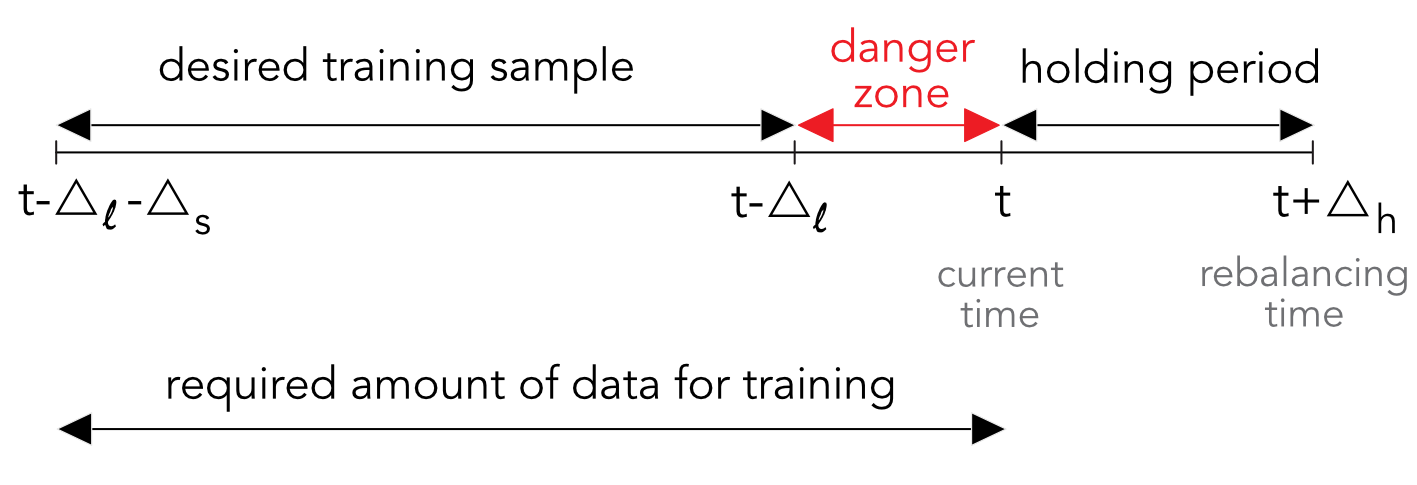

*Picture Source: Coqueret, G., & Guida, T. (2020). Machine Learning for Factor Investing: R Version. Chapman and Hall/CRC.*

**Test Period (Holding Period)**
- **Test Window:** The test data consists of **one month** at a time, immediately after the danger zone. The model predicts the **Sharpe ratio** for each stock for the next 12 months.
- **Holding Period:** The holding period for each iteration is **one month**, meaning that after the model predicts the stocks' Sharpe ratios, the portfolio is held for one month until the next rebalancing.

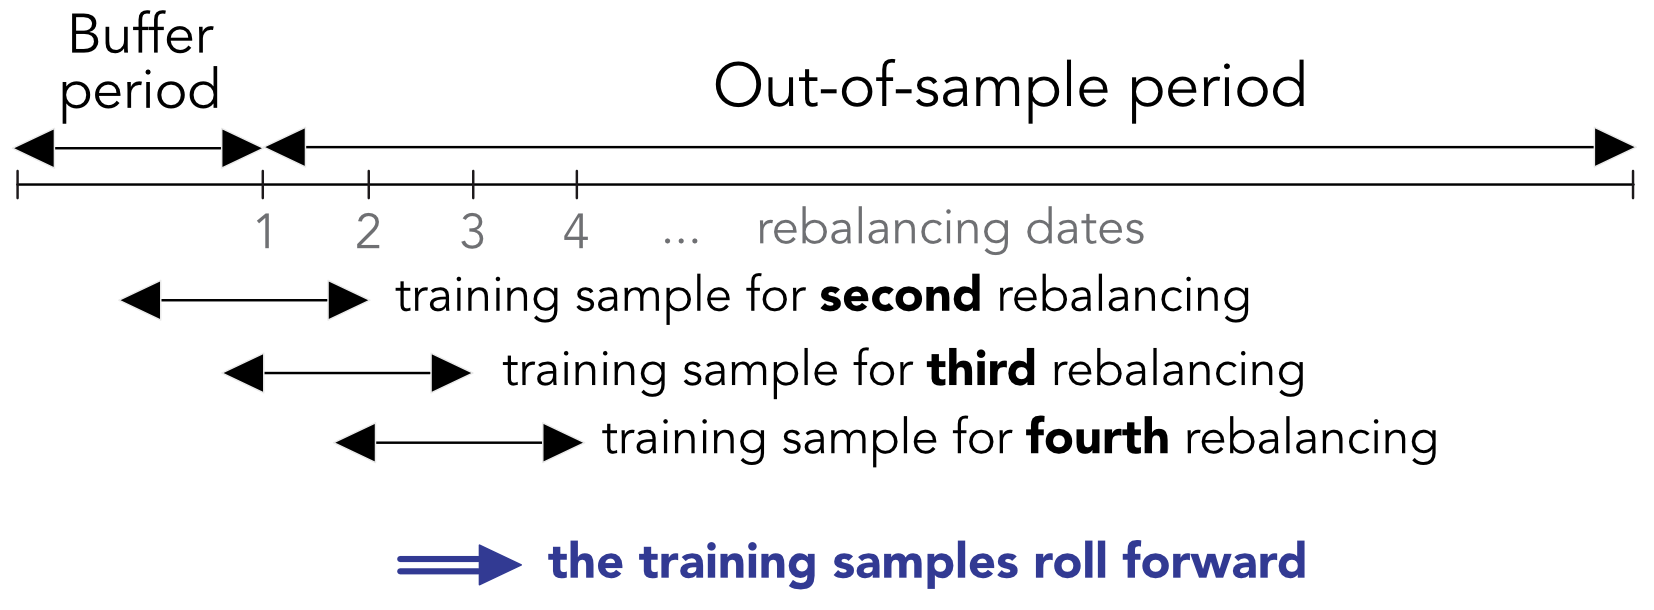

*Picture Source: Coqueret, G., & Guida, T. (2020). Machine Learning for Factor Investing: R Version. Chapman and Hall/CRC.*

**FLAML Hyperparameter Tuning**
- **FLAML** (Fast and Lightweight AutoML) is used to perform hyperparameter tuning on the training data before training the LightGBM model. The parameters are optimized for each rolling window of training data to enhance the performance for the upcoming test period.
- **Metric for Optimization:** The model is optimized for **Mean Absolute Error (MAE)**, and FLAML runs for a time-constrained **120 seconds** per iteration to find the best parameters. We use the **MAE** as our primary metric for performance evaluation due to its lower susceptibility to outliers (compared to MSE).

**Model Training and Predictions**
- **Training Phase:** For each iteration, the model is trained on the rolling 3-year training data (ending 12 months before the test date) using LightGBM.
- **Testing Phase:** The trained model is then used to predict the **1-year Sharpe ratio** (`SHARPE_1Y_USD`) for the next month. Based on these predictions, stocks are ranked by their expected Sharpe ratios.

**Rebalancing Strategy**
- **Rebalancing Frequency:** The portfolios are **rebalanced monthly**. Each month, new predictions are made for the Sharpe ratios, and the portfolio is adjusted according to these predictions.
- Two strategies are implemented:
  1. **Equal-Weighted Portfolio (EW):** In the first strategy, all stocks in the test set are assigned equal weights.
  2. **Machine Learning-Based Portfolio (ML):** In the second strategy, the stocks with the highest predicted Sharpe ratios (top 10% based on model predictions) are selected, and equal weights are assigned to those stocks.

**Portfolio Construction**
- **Equal-Weighted Portfolio (EW):** All stocks in the test month are weighted equally. This strategy serves as a baseline for comparison.
- **ML-Based Portfolio:** For the ML-based portfolio, the model selects the top 10% of stocks (based on predicted Sharpe ratios), and the portfolio weights are distributed equally across these selected stocks.
- **Realized Returns:** After selecting the stocks and computing the weights, the actual (realized) returns (`R1M_USD`) for the next month are used to calculate the portfolio's performance.

**Backtesting Execution**
- This process is repeated for every month in the backtest period. For each month:
  1. The model is trained on the past 36 months of data.
  2. The model predicts the **1-year Sharpe ratio** for the next month, and portfolios are rebalanced according to the predictions.
  3. The returns of each portfolio (equal-weighted and ML-based) are recorded and accumulated over time.

**Summary of Key Time Elements**
- **Training Sample:** A 3-year (36-month) rolling window of past data is used to train the model.
- **Danger Zone (Gap):** A 12-month gap exists between the last training date and the start of the test period to avoid data leakage.
- **Holding Period:** The model's predictions are used for a 1-month holding period, during which the selected portfolio is held.
- **Rebalancing Frequency:** Portfolios are rebalanced every month based on the latest model predictions.

*Please note that both the Sharpe ratio and alphas are calculated on a monthly basis*

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from flaml import AutoML  # Import FLAML

# Load the dataset
file_path = 'df_ml.pkl'
df = pd.read_pickle(file_path)
df = df[df['date'] < '2024-08-01']
# Define the predictors and label (SHARPE_1Y_USD) 
predictors = [
    'MKTCAP',                  # Market Capitalization
    'ASSET_TURNOVER',           # Asset Turnover
    'INVENTORY_TURNOVER',       # Inventory Turnover
    'REC_TURNOVER',             # Receivables Turnover
    'PAYABLES_TURNOVER',        # Payables Turnover
    'EBIT_BV',                  # EBIT on Book Value
    'EBIT_TA',                  # EBIT on Total Assets
    'EBITDA_SALE',              # EBITDA Margin
    'NET_MARGIN',               # Net Margin
    'NI_AT',                    # Net Income to Total Assets
    'EPS',                      # Earnings Per Share
    'EPS_DIL',                  # Diluted Earnings Per Share
    'EPS_GR',                   # EPS Growth (YoY Change)
    'FCF',                      # Free Cash Flow
    'FCF_BV',                   # Free Cash Flow to Book Value
    'FCF_SALE',                 # Free Cash Flow to Sales
    'FCF_TA',                   # Free Cash Flow to Total Assets
    'FCF_YIELD',                # Free Cash Flow Yield
    'OCF_SALES',                # Operating Cash Flow to Sales
    'PB',                       # Price-to-Book Ratio
    'PE',                       # Price-to-Earnings Ratio
    'DEBT_EQUITY',              # Debt to Equity
    'DEBT_EBITDA',              # Debt to EBITDA
    'DEBT_CF',                  # Debt to Cash Flow
    'DEBT_SALE',                # Debt to Sales
    'DEBT_AT',                  # Debt to Assets
    'INT_COVERAGE',             # Interest Coverage Ratio
    'MOM_11M_USD',              # 11-Month Momentum
    'MOM_5M_USD',               # 5-Month Momentum
    'VOL11M_USD',               # Volatility over 11 months
    'VOL5M_USD',                # Volatility over 5 months
    'MOM_SHARPE_11M_USD',       # Sharpe Ratio for 11 months
    'MOM_SHARPE_5M_USD',        # Sharpe Ratio for 5 months
    'SHARE_TURN_12M',           # 12-Month Share Turnover
    'SHARE_TURN_6M',            # 6-Month Share Turnover
    'SHARE_TURN_3M',            # 3-Month Share Turnover
    'ADV_12M_USD',              # 12-Month Average Daily Volume in USD
    'ADV_6M_USD',               # 6-Month Average Daily Volume in USD
    'ADV_3M_USD'                # 3-Month Average Daily Volume in USD
]

label = 'SHARPE_1Y_USD'  # Label (target to train on)
prediction_target = 'R1M_USD'  

# Ensure stockid is treated as categorical or numeric (convert stockid if it's a string. Optional for LGBM)
df['stockid'] = pd.factorize(df['stockid'])[0]

# Sort data by stockid and date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['stockid', 'date'])

# Generate the full range of monthly test dates, filling missing ones
sep_oos = pd.to_datetime("2005-01-01")  # Starting point for backtest
last_date = df['date'].max()
t_oos_full = pd.date_range(start=sep_oos, end=last_date, freq='M')

# Initialize portfolio weights and returns
Tt = len(t_oos_full)
nb_port = 2  # Number of portfolios/strategies (EW and LGBM)
max_stocks = df['stockid'].nunique()
portf_weights = np.zeros((Tt, nb_port, max_stocks))  # Weights per strategy
portf_returns = np.zeros((Tt, nb_port))  # Portfolio returns

# Function to use FLAML for hyperparameter optimization
def flaml_tuning(train_X, train_y):
    automl = AutoML()
    settings = {
        "time_budget": 120,  # Adjust time budget as per your constraints (120 seconds)
        "task": "regression",
        "metric": "mae",  # Focusing on MAE 
        "estimator_list": ["lgbm"],  # Use LightGBM as the estimator
        "log_file_name": "",  # Disable logging
        "verbose": -1  # Suppress FLAML output
    }
    
    # Perform the tuning
    automl.fit(train_X, train_y, **settings)
    
    # Get the best parameters
    best_params = automl.best_config
    
    # Remove the 'log_max_bin' if it exists
    if 'log_max_bin' in best_params:
        del best_params['log_max_bin']
        
    
    return best_params

# Define parameters for rolling window
m_offset = 12  # Offset in months for label
train_size = 3  # Size of training set in years

# Backtesting loop
for t in range(len(t_oos_full)):
    #print(f'Backtesting date: {t_oos_full[t]}')
    
    train_end_date = t_oos_full[t] - pd.DateOffset(months=m_offset)
    train_start_date = train_end_date - pd.DateOffset(years=train_size)

    # Training data: past cross-sectional data (3 years)
    train_data = df[(df['date'] > train_start_date) & (df['date'] <= train_end_date)]

    # Test data: the next month's cross-sectional data
    test_data = df[df['date'] == t_oos_full[t]]
    
    if test_data.empty:
        print(f"No test data found for date: {t_oos_full[t]}")
        continue

    realized_returns = test_data[prediction_target]  
    
    train_X = train_data[predictors]
    test_X = test_data[predictors]
    
    train_y = train_data[label]  # Label is SHARPE_1Y_USD
    
    # Use FLAML to find the best hyperparameters
    best_params = flaml_tuning(train_X, train_y)
    
    # Ensure 'verbosity' is set to suppress output and handle n_estimators
    best_params["verbosity"] = -1  # Suppress logs
    if 'n_estimators' in best_params:
        del best_params['n_estimators']  # Remove if duplicated
        
    for j in range(nb_port):
        if j == 0:
            N = len(test_data['stockid'])
            weights = np.repeat(1/N, N)
            stocks = test_data['stockid'].values
        else:
            dtrain = lgb.Dataset(train_X, label=train_y)
           
            model = lgb.train(best_params, dtrain)

            pred = model.predict(test_X)
            top_pred = pred > np.percentile(pred, 90)
            weights = np.where(top_pred, 1/np.sum(top_pred), 0)
            stocks = test_data['stockid'].values  # Define stocks for the ML-based strategy

        portf_weights[t, j, stocks] = weights
        portf_returns[t, j] = np.sum(weights * realized_returns)


**LGB vs Benchmark**

          avg_ret       vol  Sharpe_ratio     VaR_5
EW       0.009018  0.066145      0.136331 -0.102545
LGBM_SR  0.016213  0.061866      0.262058 -0.091098


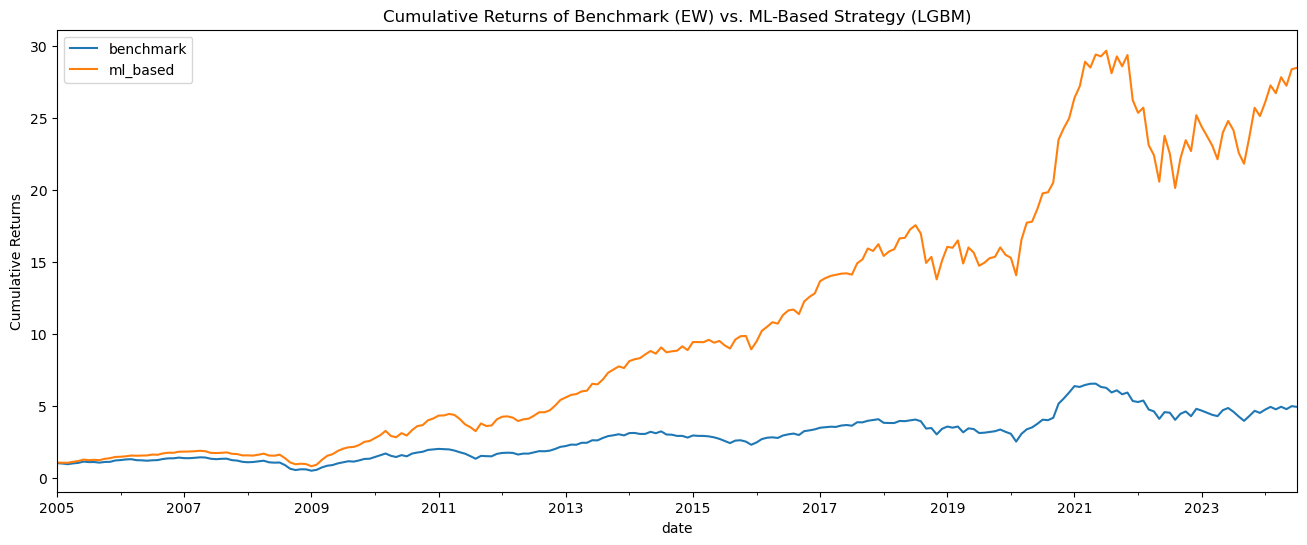

In [2]:
# Function to compute performance metrics 
def perf_met(portf_returns):
    avg_ret = np.nanmean(portf_returns)  # Arithmetic mean 
    vol = np.nanstd(portf_returns, ddof=1)  # Volatility
    Sharpe_ratio = avg_ret / vol  # Sharpe ratio
    VaR_5 = np.quantile(portf_returns, 0.05)  # Value-at-risk
    return [avg_ret, vol, Sharpe_ratio, VaR_5]

# Prepare the returns data for performance evaluation
asset_returns = df.pivot_table(index='date', columns='stockid', values=prediction_target).fillna(0)

# Compute performance metrics for each strategy
perf_metrics = []
for j in range(nb_port):
    perf_metrics.append(perf_met(portf_returns[:, j]))

perf_metrics_df = pd.DataFrame(perf_metrics, columns=['avg_ret', 'vol', 'Sharpe_ratio', 'VaR_5'], index=["EW", "LGBM_SR"])

print(perf_metrics_df)

# Plot cumulative portfolio values
g = pd.DataFrame({
    "date": t_oos_full,
    "benchmark": np.cumprod(1 + portf_returns[:, 0]),
    "ml_based": np.cumprod(1 + portf_returns[:, 1])
}).set_index('date')

g[["benchmark", "ml_based"]].plot(figsize=[16, 6], ylabel='Cumulative Returns')
plt.title('Cumulative Returns of Benchmark (EW) vs. ML-Based Strategy (LGBM)')
plt.show()

**LGB Alpha**

In [4]:
import pandas as pd
import statsmodels.api as sm
import requests
from io import BytesIO
import zipfile
import numpy as np
from pandas.tseries.offsets import MonthEnd

# Download the Fama-French 3-Factor data from Kenneth French's website
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Load the data from the relevant CSV file in the zip archive
csv_file = zip_file.open('F-F_Research_Data_Factors.CSV')

# Skip the headers and non-data rows, load relevant data
df_ff = pd.read_csv(csv_file, skiprows=4, sep=',', nrows=1178, engine='python')

# Clean the data
df_ff.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']  # Adjust the column names
df_ff = df_ff.dropna()

# Convert 'Date' from YYYYMM to datetime format
df_ff['Date'] = pd.to_datetime(df_ff['Date'], format='%Y%m') + MonthEnd(-1)  # Adjust to end of last month

# Filter the Fama-French data to the range of your backtesting
start_date = '2004-01-01'
end_date = '2024-09-30'
df_ff = df_ff[(df_ff['Date'] >= start_date) & (df_ff['Date'] <= end_date)]

# Convert the returns from percentage to decimal
df_ff['Mkt-RF'] = df_ff['Mkt-RF'] / 100
df_ff['SMB'] = df_ff['SMB'] / 100
df_ff['HML'] = df_ff['HML'] / 100
df_ff['RF'] = df_ff['RF'] / 100

# Prepare the portfolio returns data 
# Ensure t_oos_full and portf_returns are defined appropriately in your environment.
df_portfolio = pd.DataFrame({
    'Date': t_oos_full,  # Dates from the backtesting
    'EW': portf_returns[:, 0],  # EW portfolio returns
    'ML': portf_returns[:, 1]   # ML-based portfolio returns
})

# Merge Fama-French factors with the portfolio returns based on the 'Date'
df_combined = pd.merge(df_ff, df_portfolio, on='Date', how='inner')

# Calculate excess returns for the portfolios (returns - risk-free rate)
df_combined['Excess_EW'] = df_combined['EW'] - df_combined['RF']
df_combined['Excess_ML'] = df_combined['ML'] - df_combined['RF']

# Function to estimate alpha and betas using the Fama-French 3-Factor Model with Newey-West standard errors
def estimate_alpha_beta_3f_newey_west(excess_returns_portfolio, ff_factors, lags=2):
    X = sm.add_constant(ff_factors[['Mkt-RF', 'SMB', 'HML']])  # Add constant (alpha) and Fama-French factors
    model = sm.OLS(excess_returns_portfolio, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})  # Use Newey-West errors
    alpha = model.params[0]  # Alpha (intercept)
    beta_mkt_rf = model.params[1]  # Beta for Market (Mkt-RF)
    beta_smb = model.params[2]  #  for Size (SMB)
    beta_hml = model.params[3]  #  for Value (HML)
    
    return alpha, beta_mkt_rf, beta_smb, beta_hml, model

# Estimate alpha and betas for the ML-based portfolio using the 3-factor model with Newey-West standard errors
alpha_ml_3f, beta_ml_mkt, beta_ml_smb, beta_ml_hml, model_ml_3f = estimate_alpha_beta_3f_newey_west(df_combined['Excess_ML'], df_combined)
print(f'Alpha for ML-Based Portfolio (Newey-West, 3-Factor): {alpha_ml_3f:.4f}')
print(f'Beta_Mkt_RF: {beta_ml_mkt:.4f}, Beta_SMB: {beta_ml_smb:.4f}, Beta_HML: {beta_ml_hml:.4f}')

# View the full regression results for the 3-factor model with Newey-West standard errors
print(model_ml_3f.summary())

Alpha for ML-Based Portfolio (Newey-West, 3-Factor): 0.0063
Beta_Mkt_RF: 1.0922, Beta_SMB: 0.4644, Beta_HML: 0.0831
                            OLS Regression Results                            
Dep. Variable:              Excess_ML   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     112.3
Date:                Thu, 26 Sep 2024   Prob (F-statistic):           8.25e-45
Time:                        09:47:18   Log-Likelihood:                 493.76
No. Observations:                 234   AIC:                            -979.5
Df Residuals:                     230   BIC:                            -965.7
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

---

## References


Banz, R. W. (1981). The relationship between return and market value of common stocks. Journal of financial economics, 9(1), 3-18.

Chollet, F. (2021). Deep learning with Python. Simon and Schuster.

Coqueret, G., & Guida, T. (2020). Machine learning for factor investing: R version. Chapman and Hall/CRC.

DeMiguel, V., Garlappi, L., & Uppal, R. (2009). Optimal versus naive diversification: How inefficient is the 1/N portfolio strategy?. The review of Financial studies, 22(5), 1915-1953.

Dichtl, H., Drobetz, W., & Wendt, V. S. (2021). How to build a factor portfolio: Does the allocation strategy matter?. European Financial Management, 27(1), 20-58.

Fama, E. F., & French, K. R. (1995). Size and book‐to‐market factors in earnings and returns. The journal of finance, 50(1), 131-155.

Green, J., Hand, J. R., & Zhang, X. F. (2013). The supraview of return predictive signals. Review of Accounting Studies, 18, 692-730.

Griffin, J. M., Hirschey, N., & Kruger, S. (2023). Do municipal bond dealers give their customers “fair and reasonable” pricing?. The Journal of Finance, 78(2), 887-934.

Gu, S., Kelly, B., & Xiu, D. (2020). Empirical asset pricing via machine learning. The Review of Financial Studies, 33(5), 2223-2273.

Guida, T., & Coqueret, G. (2019). Ensemble learning applied to quant equity: gradient boosting in a multifactor framework. Big data and machine learning in quantitative investment, 129-148.

Harvey, C. R., Liu, Y., & Zhu, H. (2016). … and the cross-section of expected returns. The Review of Financial Studies, 29(1), 5-68.

Howard, J., & Gugger, S. (2020). Fastai: a layered API for deep learning. Information, 11(2), 108.

Howard, J., & Gugger, S. (2020). Deep Learning for Coders with fastai and PyTorch. O'Reilly Media.

Jegadeesh, N., & Titman, S. (1993). Returns to buying winners and selling losers: Implications for stock market efficiency. The Journal of finance, 48(1), 65-91.

Jegadeesh, N., & Titman, S. (2001). Profitability of momentum strategies: An evaluation of alternative explanations. The Journal of finance, 56(2), 699-720.

Ke, G., Meng, Q., Finley, T., Wang, T., Chen, W., Ma, W., ... & Liu, T. Y. (2017). Lightgbm: A highly efficient gradient boosting decision tree. Advances in neural information processing systems, 30.

Pflug, G. C., Pichler, A., & Wozabal, D. (2012). The 1/N investment strategy is optimal under high model ambiguity. Journal of Banking & Finance, 36(2), 410-417.

Subrahmanyam, A. (2010). The cross‐section of expected stock returns: what have we learnt from the past twenty‐five years of research?. European Financial Management, 16(1), 27-42.

Van Dijk, M. A. (2011). Is size dead? A review of the size effect in equity returns. Journal of Banking & Finance, 35(12), 3263-3274.

---

## Appendix

*This appendix provides instructions for downloading stock tickers from Tiingo*

In [ ]:
from tiingo import TiingoClient
import os

In [ ]:
def initialize_tiingo_client():
    config = {
        'session': True,
        'api_key': os.getenv('TIINGO_API_KEY')
    } 
    if not config['api_key']:
        raise Exception("API key not found! Please set your Tiingo API key as an environment variable.")
    return TiingoClient(config) 

In [ ]:
# API Key
import os
os.environ['TIINGO_API_KEY'] = "YOUR API KEY"

In [ ]:
client = initialize_tiingo_client()

In [ ]:
# Get all stock tickers
tickers_data = client.list_stock_tickers()

# Extract tickers into a list
ticker_symbols = [ticker['ticker'] for ticker in tickers_data]

In [ ]:
filtered_tickers = [
    ticker['ticker'] for ticker in tickers_data
    if ticker['assetType'] == 'Stock' and 
    ticker['priceCurrency'] == 'USD' and
    (ticker['exchange'] == 'NYSE' or ticker['exchange'] == 'NASDAQ'or ticker['exchange'] == 'AMEX')]

In [ ]:
# Save the filtered tickers to a .txt file
with open('filtered_tickers.txt', 'w') as file:
    for ticker in filtered_tickers:
        file.write(f"{ticker}\n")